## Anweisung zur Durchführung der Datenfilterung und Weiterverarbeitung

Im Rahmen unseres Projektes wurde eine umfassende Erhebung von nutzergenerierten Daten aus der Plattform TikTok durchgeführt. Diese Daten werden nun einer systematischen Aufbereitung und Filterung unterzogen, um sie für die anschließende Weiterverarbeitung vorzubereiten.

Ein wesentlicher Bestandteil dieses Prozesses ist die Identifikation deutscher Inhalte, welche durch speziell entwickelte Erkennungsverfahren erfolgt. Zudem findet eine manuelle Selektion statt, bei welcher durch den Einsatz einer Blacklist unerwünschte Kanäle ausgeschlossen werden.

________________

____________

### Datenbank sichten
Alle Feststellungen sind akribisch zu dokumentiet worden. Die sqlite3 Datenbank wird zur weiteren Verarbeitung in ein Dataframe überführt.

In [207]:
# Datenbankinhalt in einen Pandas-DataFrame laden

import pandas as pd
import sqlite3
def db_to_dataframe(db_name="tiktok_media_metadata.db"):
    conn = sqlite3.connect(db_name)
    query = "SELECT * FROM media_metadata"
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except sqlite3.Error as e:
        print(f"Fehler: {e}")
        return None
    finally:
        conn.close()

df = db_to_dataframe()

df

id                                                url  \
0      7453041971486133536  https://www.tiktok.com/@gereonbollmann/video/7...   
1      7446314527685201185  https://www.tiktok.com/@gereonbollmann/video/7...   
2      7430740655854390560  https://www.tiktok.com/@gereonbollmann/video/7...   
3      7429638543347076385  https://www.tiktok.com/@gereonbollmann/video/7...   
4      7424819005254405408  https://www.tiktok.com/@gereonbollmann/video/7...   
...                    ...                                                ...   
43794  7462626087110020374  https://www.tiktok.com/@martinschmidtafd/video...   
43795  7462788634048056598  https://www.tiktok.com/@jan.abicht/video/74627...   
43796  7462742615704800534  https://www.tiktok.com/@peterboehringerafd/vid...   
43797  7462709945624956192  https://www.tiktok.com/@afd.kv.salzgitter/vide...   
43798  7458652747630447904  https://www.tiktok.com/@afd.kv.salzgitter/vide...   

                                                   title  \
0      Zur Lösung der angespannten Situation auf unse...   
1      Eine #Petition hat den Deutschen Bundestag err...   
2      Warum nur die Politik der AfD für Sicherheit i...   
3      Wir brauchen Erleichterungen für beruflich sel...   
4      Als Mitglied des Familienausschusses und Vorsi...   
...                                                  ...   
43794                        Es wird episch. #afd #afdmv   
43795                                                      
43796      Vertraut ihr Merz noch?#explore #viral #merz    
43797  Große Herausforderung #AfD #aliceweidel #rassi...   
43798  Kanzlerkandidatin Alice Weidel AfD-Bundesparte...   

                                             description  duration  \
0      Zur Lösung der angespannten Situation auf unse...     173.0   
1      Eine #Petition hat den Deutschen Bundestag err...     154.0   
2      Warum nur die Politik der AfD für Sicherheit i...      56.0   
3      Wir brauchen Erleichterungen für beruflich sel...     232.0   
4      Als Mitglied des Familienausschusses und Vorsi...     228.0   
...                                                  ...       ...   
43794                        Es wird episch. #afd #afdmv      15.0   
43795                                                         60.0   
43796      Vertraut ihr Merz noch?#explore #viral #merz       45.0   
43797  Große Herausforderung #AfD #aliceweidel #rassi...      67.0   
43798  Kanzlerkandidatin Alice Weidel AfD-Bundesparte...     372.0   

       view_count  like_count  repost_count  comment_count  \
0             903         112             1              8   
1             910         104             0              5   
2             888         103             1              8   
3             370          44             5              6   
4            1358         146             1              7   
...           ...         ...           ...            ...   
43794         682          68             6             10   
43795           3           2             0              0   
43796        2843         652            13             98   
43797         302          73             0              4   
43798      386700       43500          4303           4360   

                 uploader          uploader_id             channel  \
0          gereonbollmann  7240807959155098651      GereonBollmann   
1          gereonbollmann  7240807959155098651      GereonBollmann   
2          gereonbollmann  7240807959155098651      GereonBollmann   
3          gereonbollmann  7240807959155098651      GereonBollmann   
4          gereonbollmann  7240807959155098651      GereonBollmann   
...                   ...                  ...                 ...   
43794    martinschmidtafd  6963962486161638405  Martin Schmidt MdL   
43795          jan.abicht  7420674644824441888          Jan Abicht   
43796  peterboehringerafd  7275292338376262688  peterboehringerafd   
43797   afd.kv.salzgitter  73346771494017935

___________

## False-Positve-Filter

Dieser Prozess nutzt spezialisierte Erkennungsverfahren, um fälschlicherweise als positiv klassifizierte Sprachinhalte zu identifizieren und zu korrigieren. Folgende Schritte sind im verfahrenstechnischen Ablauf zu beachten:

Die Erkennung deutscher Sprachinhalte erfolgt durch das erstmalige Bereinigen der zu prüfenden Texte von  vorhandenen Hashtags.  Es werden analytische Maßnahmen angewendet, die anhand von Wahrscheinlichkeiten das Vorhandensein der deutschen Sprache innerhalb gegebener Inhalte bestätigen oder ablehnen.  Basierend auf den Ergebnissen wird der Datenbestand in besonders gekennzeichnete Textdateien geteilt, die dann zur weiteren Bearbeitung an die entsprechenden Stellen zugewiesen werden können.







In [179]:
import pandas as pd
from langdetect import detect_langs
import logging
from logging.handlers import RotatingFileHandler

# Einrichtung des Loggings mit RotatingFileHandler (max. 10 MB, dann Überschreibung)
logger = logging.getLogger("GermanDetection")
logger.setLevel(logging.DEBUG)
handler = RotatingFileHandler("process.log", maxBytes=10*1024*1024, backupCount=1)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def is_german(text):
    try:
        # Entferne Hashtags, bevor die Sprache erkannt wird
        text_without_hashtags = ' '.join(word for word in text.split() if not word.startswith('#'))
        # Falls kein anderer Text nach dem Entfernen von Hashtags übrig bleibt
        if not text_without_hashtags.strip():
            return False

        # Erkennung der Sprache und Überprüfung der Wahrscheinlichkeit
        detected_languages = detect_langs(text_without_hashtags)
        for lang in detected_languages:
            if lang.lang == 'de' and lang.prob > 0.7:
                return True
        return False

    except Exception as e:
        logger.warning(f"Fehler beim Erkennen der Sprache: {e}")
        return False

logger.info("Starte Spracherkennung für DataFrame")

# Anwenden der Sprachprüfung auf Titel und Beschreibungen
df['german_title'] = df['title'].apply(is_german)
df['german_description'] = df['description'].apply(lambda x: is_german(x) if isinstance(x, str) else False)

logger.info("Spracherkennung abgeschlossen, gruppiere nach Uploader")

# Gruppierung nach Uploader und Aggregation der deutschen Inhalte
grouped = df.groupby('uploader').agg(
    total_entries=('title', 'count'),
    german_title_sum=('german_title', 'sum'),
    german_desc_sum=('german_description', 'sum')
)

grouped['german_average'] = (grouped['german_title_sum'] + grouped['german_desc_sum']) / (2 * grouped['total_entries'])

# Auswahl der Uploader, die den deutschen Schwellenwert erfüllen
eligible_uploaders = grouped[grouped['german_average'] > 0.5].index.tolist()
logger.info(f"Anzahl der gefilterten Uploader: {len(eligible_uploaders)}")

# Ermittlung der Uploader, die den Schwellenwert nicht erfüllen
all_uploaders = grouped.index.tolist()
non_eligible_uploaders = list(set(all_uploaders) - set(eligible_uploaders))
logger.info(f"Anzahl der nicht gefilterten Uploader: {len(non_eligible_uploaders)}")

# Filterung des ursprünglichen DataFrames nach den berechtigten Uploadern
result_df = df[df['uploader'].isin(eligible_uploaders)].copy()
logger.info(f"Ergebnis-DataFrame enthält {len(result_df)} Einträge")

# Ausgabe des gefilterten DataFrames in Jupyter Notebook
result_df

# Erstellen einer positives.txt mit detaillierten Informationen der gefilterten Einträge
with open("positives.txt", "w", encoding="utf-8") as f:
    for idx, row in result_df.iterrows():
        f.write(f"Uploader: {row['uploader']}\n")
        f.write(f"Title: {row['title']}\n")
        f.write(f"Description: {row.get('description', '')}\n")
        f.write("-" * 40 + "\n")

logger.info("positives.txt wurde erstellt.")

# Erstellen einer negatives.txt mit den unique Uploadern, die nicht die Kriterien erfüllen
with open("negatives.txt", "w", encoding="utf-8") as f:
    for uploader in non_eligible_uploaders:
        f.write(f"{uploader}\n")

logger.info("negatives.txt wurde erstellt.")


In [180]:
result_df

id                                                url  \
0      7453041971486133536  https://www.tiktok.com/@gereonbollmann/video/7...   
1      7446314527685201185  https://www.tiktok.com/@gereonbollmann/video/7...   
2      7430740655854390560  https://www.tiktok.com/@gereonbollmann/video/7...   
3      7429638543347076385  https://www.tiktok.com/@gereonbollmann/video/7...   
4      7424819005254405408  https://www.tiktok.com/@gereonbollmann/video/7...   
...                    ...                                                ...   
43424  7461715778568572182  https://www.tiktok.com/@afd_hessen_of_land/vid...   
43427  7461690620634090774  https://www.tiktok.com/@afd_northeim/video/746...   
43429  7461711677419998486  https://www.tiktok.com/@dennishohloch.afd/vide...   
43430  7461666686840622358  https://www.tiktok.com/@dennishohloch.afd/vide...   
43433  7461704230974295318  https://www.tiktok.com/@maximilian_krah/video/...   

                                                   title  \
0      Zur Lösung der angespannten Situation auf unse...   
1      Eine #Petition hat den Deutschen Bundestag err...   
2      Warum nur die Politik der AfD für Sicherheit i...   
3      Wir brauchen Erleichterungen für beruflich sel...   
4      Als Mitglied des Familienausschusses und Vorsi...   
...                                                  ...   
43424                                      Alice Weidel    
43427  Spontanes Interview mit Louis L.. Er hatte die...   
43429                     Wer hat Schuld an #Magdeburg?    
43430  #Schweden macht Schluss mit der illegalen #Mig...   
43433        Wir brauchen echte Männer und echte Frauen!   

                                             description  duration  \
0      Zur Lösung der angespannten Situation auf unse...     173.0   
1      Eine #Petition hat den Deutschen Bundestag err...     154.0   
2      Warum nur die Politik der AfD für Sicherheit i...      56.0   
3      Wir brauchen Erleichterungen für beruflich sel...     232.0   
4      Als Mitglied des Familienausschusses und Vorsi...     228.0   
...                                                  ...       ...   
43424                                      Alice Weidel       18.0   
43427  Spontanes Interview mit Louis L.. Er hatte die...     393.0   
43429                     Wer hat Schuld an #Magdeburg?       95.0   
43430  #Schweden macht Schluss mit der illegalen #Mig...      74.0   
43433        Wir brauchen echte Männer und echte Frauen!      76.0   

       view_count  like_count  repost_count  comment_count  \
0             892         112             1              8   
1             907         104             0              5   
2             885         103             1              8   
3             369          44             5              6   
4            1358         146             1              7   
...           ...         ...           ...            ...   
43424         339         104             1             13   
43427         350          85            29              8   
43429        1093         121             6              8   
43430        8020        1571            71            124   
43433       10400        1712           137             80   

                 uploader  ...                    channel  \
0          gereonbollmann  ...             GereonBollmann   
1          gereonbollmann  ...             GereonBollmann   
2          gereonbollmann  ...             GereonBollmann   
3          gereonbollmann  ...             GereonBollmann   
4          gereonbollmann  ...             GereonBollmann   
...                   ...  ...                        ...   
43424  afd_hessen_of_land  ...        AfD_Hessen_Kreis_Of   
43427        afd_northeim  ...  Afd Kreisverband Northeim   
43429   dennishohloch.afd  ...          dennishohloch.afd   
43430   dennishohloch.afd  ...          dennishohloch.afd   
43433     maximilian_krah  ...        Maximilian_Krah.AfD   

           

__________

### Tiktok-Kanal-Blacklist anwenden

Gemäß der geltenden Dienstvorschrift ist eine umfassende Überprüfung der Tiktok-Kanäle vorzunehmen, wobei die bestehende Blacklist mit erhöhter Sorgfalt anzuwenden ist.



In [181]:
import pandas as pd
# Blacklist einlesen
with open('blacklist.txt', 'r') as file:
    blacklist = [line.strip() for line in file if line.strip()]

# Filterung des DataFrames: Behalte nur die Einträge, deren Uploader NICHT in der Blacklist ist
filtered_result_df = result_df[~result_df['uploader'].isin(blacklist)]

# Anzeigen des gefilterten DataFrames
filtered_result_df

id                                                url  \
0      7453041971486133536  https://www.tiktok.com/@gereonbollmann/video/7...   
1      7446314527685201185  https://www.tiktok.com/@gereonbollmann/video/7...   
2      7430740655854390560  https://www.tiktok.com/@gereonbollmann/video/7...   
3      7429638543347076385  https://www.tiktok.com/@gereonbollmann/video/7...   
4      7424819005254405408  https://www.tiktok.com/@gereonbollmann/video/7...   
...                    ...                                                ...   
43424  7461715778568572182  https://www.tiktok.com/@afd_hessen_of_land/vid...   
43427  7461690620634090774  https://www.tiktok.com/@afd_northeim/video/746...   
43429  7461711677419998486  https://www.tiktok.com/@dennishohloch.afd/vide...   
43430  7461666686840622358  https://www.tiktok.com/@dennishohloch.afd/vide...   
43433  7461704230974295318  https://www.tiktok.com/@maximilian_krah/video/...   

                                                   title  \
0      Zur Lösung der angespannten Situation auf unse...   
1      Eine #Petition hat den Deutschen Bundestag err...   
2      Warum nur die Politik der AfD für Sicherheit i...   
3      Wir brauchen Erleichterungen für beruflich sel...   
4      Als Mitglied des Familienausschusses und Vorsi...   
...                                                  ...   
43424                                      Alice Weidel    
43427  Spontanes Interview mit Louis L.. Er hatte die...   
43429                     Wer hat Schuld an #Magdeburg?    
43430  #Schweden macht Schluss mit der illegalen #Mig...   
43433        Wir brauchen echte Männer und echte Frauen!   

                                             description  duration  \
0      Zur Lösung der angespannten Situation auf unse...     173.0   
1      Eine #Petition hat den Deutschen Bundestag err...     154.0   
2      Warum nur die Politik der AfD für Sicherheit i...      56.0   
3      Wir brauchen Erleichterungen für beruflich sel...     232.0   
4      Als Mitglied des Familienausschusses und Vorsi...     228.0   
...                                                  ...       ...   
43424                                      Alice Weidel       18.0   
43427  Spontanes Interview mit Louis L.. Er hatte die...     393.0   
43429                     Wer hat Schuld an #Magdeburg?       95.0   
43430  #Schweden macht Schluss mit der illegalen #Mig...      74.0   
43433        Wir brauchen echte Männer und echte Frauen!      76.0   

       view_count  like_count  repost_count  comment_count  \
0             892         112             1              8   
1             907         104             0              5   
2             885         103             1              8   
3             369          44             5              6   
4            1358         146             1              7   
...           ...         ...           ...            ...   
43424         339         104             1             13   
43427         350          85            29              8   
43429        1093         121             6              8   
43430        8020        1571            71            124   
43433       10400        1712           137             80   

                 uploader  ...                    channel  \
0          gereonbollmann  ...             GereonBollmann   
1          gereonbollmann  ...             GereonBollmann   
2          gereonbollmann  ...             GereonBollmann   
3          gereonbollmann  ...             GereonBollmann   
4          gereonbollmann  ...             GereonBollmann   
...                   ...  ...                        ...   
43424  afd_hessen_of_land  ...        AfD_Hessen_Kreis_Of   
43427        afd_northeim  ...  Afd Kreisverband Northeim   
43429   dennishohloch.afd  ...          dennishohloch.afd   
43430   dennishohloch.afd  ...          dennishohloch.afd   
43433     maximilian_krah  ...        Maximilian_Krah.AfD   

           

In [186]:
df = filtered_result_df

__________________

____________________

## Verteilung der Videolänge des Videoarchivs


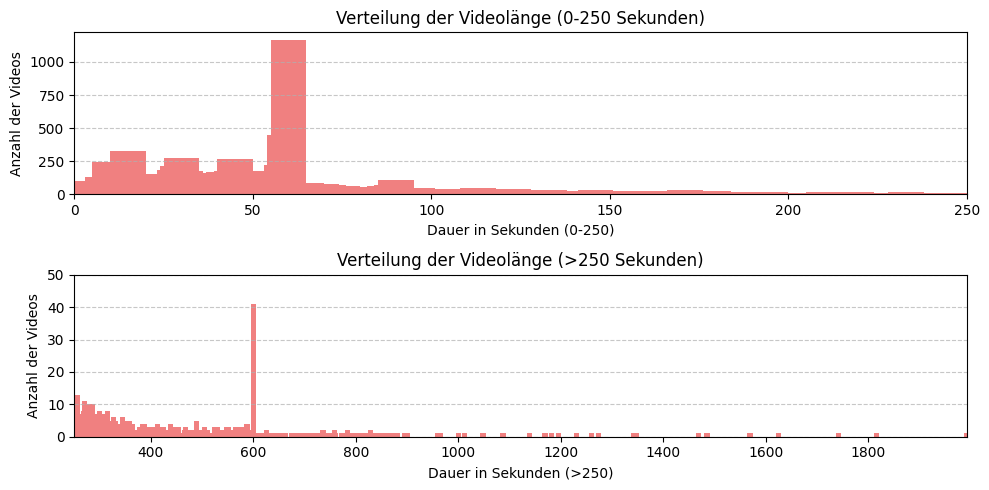

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Gesamtzeit in Sekunden berechnen
total_duration_seconds = df['duration'].sum()

# Gesamtzeit in Tage, Stunden, Minuten und Sekunden umrechnen
total_days = total_duration_seconds // (24 * 3600)
total_hours = (total_duration_seconds % (24 * 3600)) // 3600
total_minutes = (total_duration_seconds % 3600) // 60
total_seconds = total_duration_seconds % 60

# Häufigkeiten der Dauer berechnen
duration_counts = df['duration'].value_counts().sort_index()

# Erstelle eine Figur mit zwei Subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Erster Subplot: 0 bis 250 Sekunden
axes[0].bar(duration_counts.index, duration_counts.values, width=10.0, color='lightcoral')
axes[0].set_xlim(0, 250)
axes[0].set_xlabel('Dauer in Sekunden (0-250)')
axes[0].set_ylabel('Anzahl der Videos')
axes[0].set_title('Verteilung der Videolänge (0-250 Sekunden)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Zweiter Subplot: >250 Sekunden, mit y-Achse bis 50
axes[1].bar(duration_counts.index, duration_counts.values, width=10.0, color='lightcoral')
axes[1].set_xlim(251, df['duration'].max())
axes[1].set_ylim(0, 50)
axes[1].set_xlabel('Dauer in Sekunden (>250)')
axes[1].set_ylabel('Anzahl der Videos')
axes[1].set_title('Verteilung der Videolänge (>250 Sekunden)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Layout anpassen
plt.tight_layout()

# Diagramme anzeigen
plt.show()

# HTML-Text mit einfacher Struktur und einer kleinen Überschrift erstellen
html_content = f"""
<h3>Videogesamtdauer</h3>
<p>Sekunden: {total_duration_seconds:,}</p>
<p>Tage: {total_days}, Stunden: {total_hours}, Minuten: {total_minutes}, Sekunden: {total_seconds}</p>
"""

# HTML anzeigen
display(HTML(html_content))

________________


## How much is the fish?
### Wer hat die meistern Likes, Kommentare, Reposts oder Views ?

Das Skript vergleicht verschiedene TikTok-Kanäle anhand der Metriken "view_count", "like_count", "repost_count" und "comment_count". Es summiert die Werte jeder Metrik für jeden Kanal und erstellt für jede Metrik ein eigenes Balkendiagramm. Die Diagramme zeigen, wie die einzelnen Kanäle in Bezug auf diese Interaktionen abschneiden.


In [199]:
import altair as alt
import pandas as pd
from IPython.display import HTML, display

# Summe für jede Metrik pro Channel 
columns_to_plot = ["view_count", "like_count", "repost_count", "comment_count"]
aggregated_data = (
    df.groupby(["channel", "channel_url", "uploader"])[columns_to_plot].sum().reset_index()
    .melt(id_vars=["channel", "channel_url", "uploader"], var_name="metric", value_name="value")
)

# Top 50 Channels nach Metrik
def get_top_50(df, metric_column):
    top_50_channels = (
        df[df["metric"] == metric_column]
        .nlargest(50, "value")["channel"]
        .unique()
    )
    return df[df["channel"].isin(top_50_channels)]

filtered_data = pd.concat([get_top_50(aggregated_data, metric) for metric in columns_to_plot])

# Interaktive Balkendiagramme 
charts = []
for metric in columns_to_plot:
    chart = (
        alt.Chart(filtered_data[filtered_data["metric"] == metric])
        .mark_bar()
        .encode(
            x=alt.X("channel:O", title="Channel", sort="-y", axis=alt.Axis(labelAngle=-45)),
            y=alt.Y("value:Q", title=f"Total {metric.capitalize()}"),
            color=alt.Color("channel:N", legend=None),
            tooltip=[
                alt.Tooltip("channel:N", title="Channel"),
                alt.Tooltip("uploader:N", title="Uploader"),
                alt.Tooltip("value:Q", title=f"Total {metric.capitalize()}"),
            ],
        )
        .properties(
            title=f"Total {metric.capitalize()} by Channel",
            height=300,
            width=580  # Setze die Breite auf 500
        )
    )
    # Trennelement
    separator = (
        alt.Chart(pd.DataFrame({"y": [0]}))
        .mark_rule(strokeDash=[5, 5], size=1)
        .encode(y=alt.Y("y:Q", axis=None))
        .properties(height=10, width=500)
    )
    charts.extend([chart, separator])

# Subplots 
final_chart = alt.vconcat(*charts).resolve_scale(color="independent")

# Config
final_chart = final_chart.configure_axis(
    labelFontSize=7,
    titleFontSize=16
)

# Wandelt den Chart in JSON um
chart_json = final_chart.to_json()

# HTML-Template Klickbar
html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <script src="https://cdn.jsdelivr.net/npm/vega@5"></script>
    <script src="https://cdn.jsdelivr.net/npm/vega-lite@4.17"></script>
    <script src="https://cdn.jsdelivr.net/npm/vega-embed@6"></script>
</head>
<body>
<div id="vis"></div>
<script type="text/javascript">
    var spec = {chart_json};
    vegaEmbed('#vis', spec).then(function(result) {{
        // Klick-Ereignis-Listener 
        result.view.addEventListener('click', function(event, item) {{
            if(item.datum && item.datum.channel_url) {{
                window.open(item.datum.channel_url, '_blank');
            }}
        }});
    }}).catch(console.error);
</script>
</body>
</html>
"""
display(HTML(html_template))

In [200]:
import pandas as pd
import altair as alt

# Annahme: Der DataFrame `df` ist bereits aus der Datenbank geladen

# Blacklist aus `blacklist.txt` laden
with open('blacklist.txt', 'r') as file:
    blacklist = {line.strip() for line in file if line.strip()}

# DataFrame filtern: Einträge ausschließen, deren Uploader in der Blacklist ist
df_filtered = df[~df['uploader'].isin(blacklist)]

columns_to_plot = ["view_count", "like_count", "repost_count", "comment_count"]
top_n = 50  # Für Altair-Plot
charts = []

# Altair-Plot für die Top 50 Einträge pro Metrik
for col in columns_to_plot:
    # Top 50 Einträge für die jeweilige Spalte auswählen und absteigend sortieren
    df_sorted = df_filtered.nlargest(top_n, col).sort_values(by=col, ascending=False).copy()
    # Labels kürzen, um nur den Uploader anzuzeigen
    df_sorted["channel_label"] = df_sorted["uploader"]
    
    chart = (
        alt.Chart(df_sorted)
        .mark_bar(size=30)  # Breitere Balken
        .encode(
            x=alt.X(f"{col}:Q", 
                    title=col.capitalize(), 
                    axis=alt.Axis(format=".2s")),  # Tausender mit 'K' abgekürzt
            y=alt.Y("channel_label:N",
                    title="Uploader",
                    sort=df_sorted["channel_label"].tolist()),
            color=alt.Color("uploader:N", title="Uploader",
                            legend=alt.Legend(orient='right', title="Uploader")),
            tooltip=[
                "url", 
                "title", 
                "duration", 
                "view_count", 
                "like_count", 
                "repost_count", 
                "comment_count"
            ],
            href="url:N"  # Beim Klicken auf den Balken wird die URL geöffnet
        )
        .properties(
            title=f"Top {top_n} - {col.capitalize()}",
            width=600,  # Maximale Breite auf 600 begrenzt
            height=600,
        )
    )
    charts.append(chart)

# Alle Subplots vertikal anordnen
final_chart = alt.vconcat(*charts)
final_chart.show()

alt.VConcatChart(...)

_____________

### Veröffentlichungen pro Tag 

Das Skript verarbeitet Daten zu Videoveröffentlichungen, wandelt Zeitstempel in jahres- und tagesbezogene Formate um und gruppiert sie nach Jahr, Tag und Kanal, um die Anzahl der Veröffentlichungen zu zählen. Anschließend erstellt es ein facettiertes Balkendiagramm, das die tägliche Veröffentlichungsaktivität pro Jahr und Kanal visualisiert.

Unter den Ausgewählten Kanälen lassen sich somit viele Trends in der Nutzung abbilden.

In [206]:
import pandas as pd
import altair as alt

# Zeilenbegrenzung in Altair deaktivieren
alt.data_transformers.disable_max_rows()

# Angenommen, df existiert und enthält eine 'timestamp' Spalte
# Erstelle eine Kopie des DataFrames
df_copy = df.copy()

# Zeitbezogene Spalten erstellen
df_copy["datetime"] = pd.to_datetime(df_copy["timestamp"], unit='s')
df_copy["year"] = df_copy["datetime"].dt.year
df_copy["day"] = df_copy["datetime"].dt.floor('D')

# Gruppierung: Anzahl der Videos pro Tag und Uploader zählen
df_counts = (
    df_copy.groupby(["year", "day", "uploader", "channel_url"])  # uploader anstelle von channel
    .size()
    .reset_index(name='count')
)

# Sicherstellen, dass 'day' im richtigen Format vorliegt
df_counts["day"] = pd.to_datetime(df_counts["day"])

# Altair-Chart erstellen: Subplot für jedes Jahr mit jahresspezifischer x-Achse
chart = alt.Chart(df_counts).mark_bar().encode(
    x=alt.X("day:T", 
            title="Datum", 
            scale=alt.Scale(nice=False)),
    y=alt.Y("sum(count):Q", title="Anzahl Veröffentlichungen"),
    color=alt.Color("uploader:N", title="Uploader",
                    legend=alt.Legend(orient="right", labelFontSize=12, titleFontSize=14)),
    tooltip=[
        alt.Tooltip("day:T", title="Datum"),
        alt.Tooltip("uploader:N", title="Uploader"),
        alt.Tooltip("sum(count):Q", title="Veröffentlichungen")
    ],
    href="channel_url:N"  # Link als klickbarer Button
).properties(
    width=500  # Setze die Breite nach Bedarf
).facet(
    row=alt.Row("year:N", title="Jahr")
).resolve_scale(
    x="independent",
    y="independent"
)

chart

alt.FacetChart(...)

In [ ]:
## Hashtag-Wortwolke

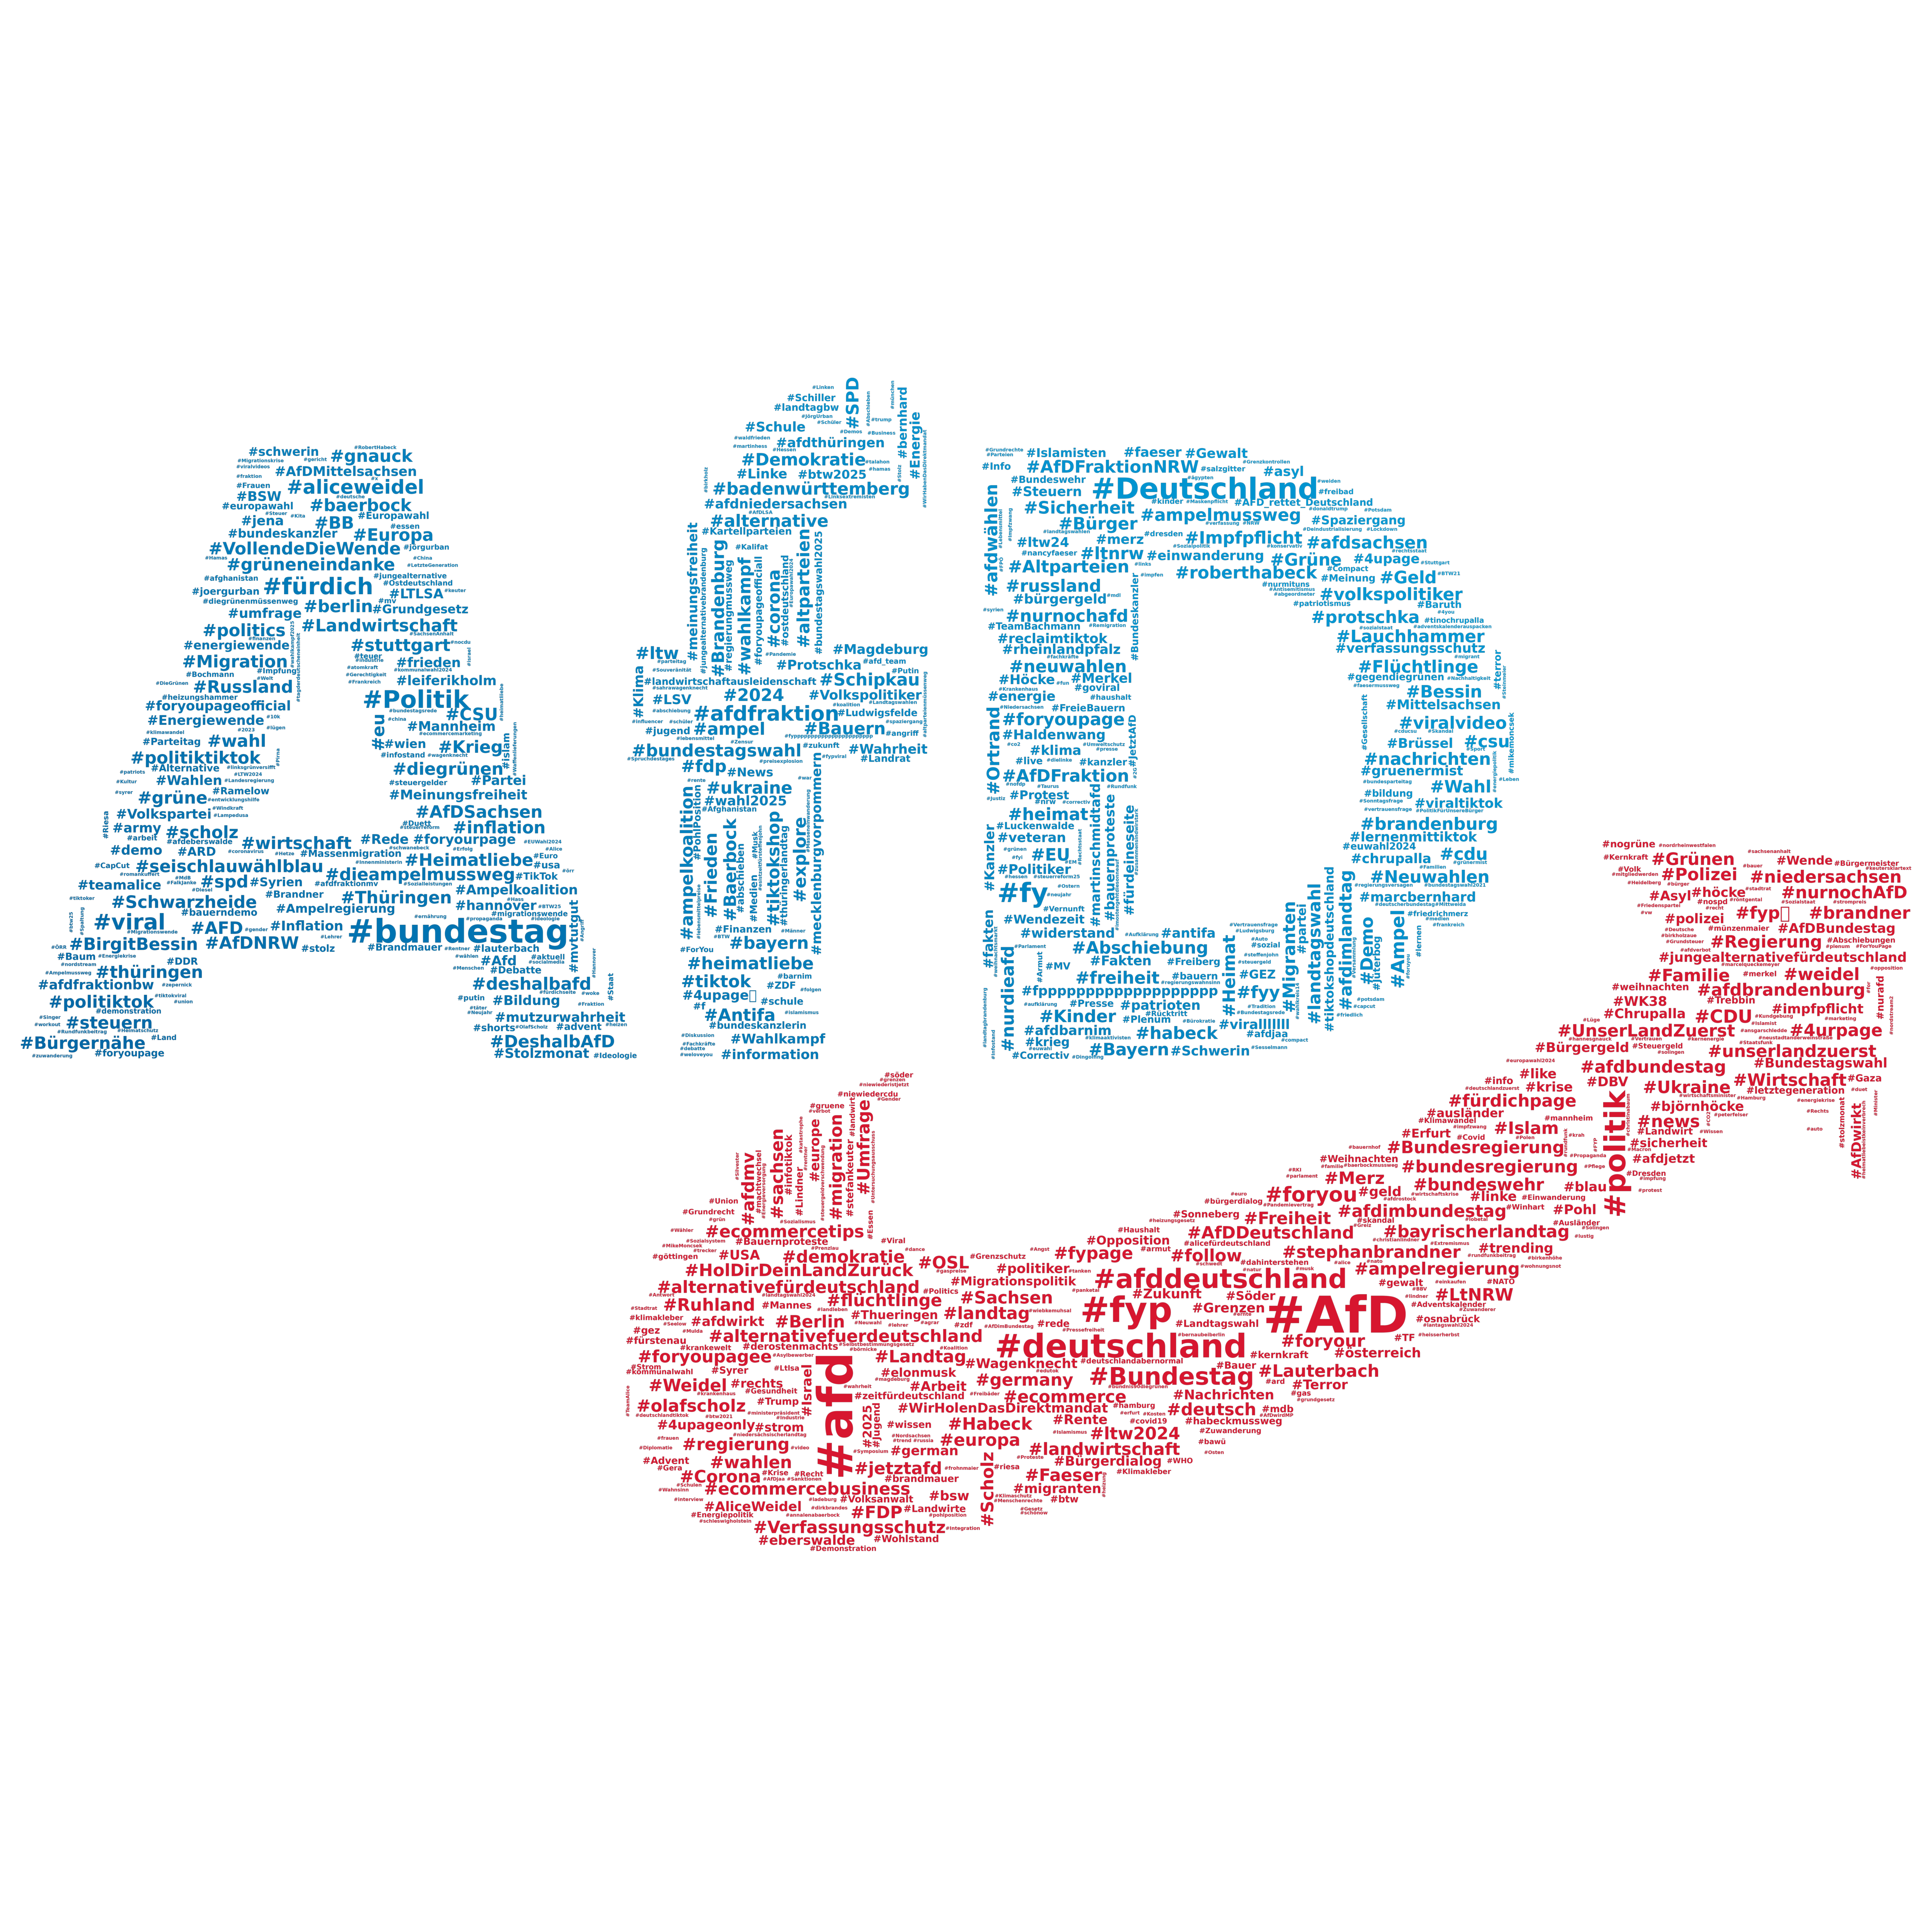

In [148]:
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans

# Bild laden und in ein numpy-Array umwandeln für die Masken- und Farbdaten
image_path = 'logo_postprocess.png'
mask = np.array(Image.open(image_path))
image_color = Image.open(image_path).convert('RGB')
np_image_rgb = np.array(image_color)

# Farbfunktion, die die Farbe jedes Wortes basierend auf seiner Position im Bild zuweist
def precise_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    x = int(position[1] + font_size / 2)
    y = int(position[0] + font_size / 2)
    if x >= np_image_rgb.shape[1] or y >= np_image_rgb.shape[0]:
        return "rgb(255, 255, 255)"  # Rückgabe weißer Farbe als Fallback
    color = np_image_rgb[y, x]
    return "rgb({},{},{})".format(color[0], color[1], color[2])

# Alle Hashtags aus der "title" Spalte extrahieren
all_text = ' '.join(df['title'].dropna())
hashtags = re.findall(r'#\w+', all_text)

# Zähle die Häufigkeit jedes Hashtags
hashtag_freq = pd.Series(hashtags).value_counts().to_dict()

# Erzeugen der Wortwolke von Hashtags
wc = WordCloud(
    background_color=None,  
    mode="RGBA",
    max_words=7800,
    mask=mask,
    scale=8,
    color_func=precise_color_func,
    font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
    max_font_size=42
).generate_from_frequencies(hashtag_freq)

# Anzeigen der Wortwolke
plt.figure(figsize=(60, 60))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("high_quality_wordcloud_hashtags.png", format='png')
plt.show()